In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv("/content/insurance.csv")

In [ ]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# **EDA Apply**

In [ ]:
#EDA
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print("##########################################\n")
    print(dataframe[numerical_col].describe(quantiles).T, end="\n\n")
    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()


def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    parameters
    ------
        dataframe: dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                Categorical view cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 returned lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


def target_summary_with_cat(dataframe, target, categorical_col):
    print(f"Mean of {target} with respect to {categorical_col}")
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def target_summary_with_num(dataframe, target, numerical_col):
    print(f"Mean of {target} with respect to {numerical_col}")
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")
    


def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu",annot=True)
        plt.show()
    return drop_list

def target_correlation_matrix(dataframe, corr_th=0.5, target=""):
    """
    Returns the variables that have a correlation above the threshold value given with the dependent variable.
    :param dataframe:
    :param corr_th: threshold value
    :param target:  dependent variable
    :return:
    """
    corr = dataframe.corr()
    corr_th = corr_th
    try:
        filter = np.abs(corr[target]) > corr_th
        corr_features = corr.columns[filter].tolist()
        sns.clustermap(dataframe[corr_features].corr(), annot=True, fmt=".2f")
        plt.show()
        return corr_features
    except:
        print("High threshold value, decrease corr_th value!")


In [ ]:
check_df(df)
cat_cols, num_cols, cat_but_car = grab_col_names(df)

##################### Shape #####################
(1338, 7)
##################### Types #####################
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
##################### Head #####################
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
##################### Tail #####################
      age     sex    bmi  children smoker     region     charges
1333   50    male  30.97         3     no  northwest  10600.5483
1334   18  female  31.92         0     no  northeast   2205.9808
1335   18  female  36.85         0     no  southeast   1629

**Categorical Columns Visualization and Summarization**

        sex      Ratio
male    676  50.523169
female  662  49.476831
##########################################


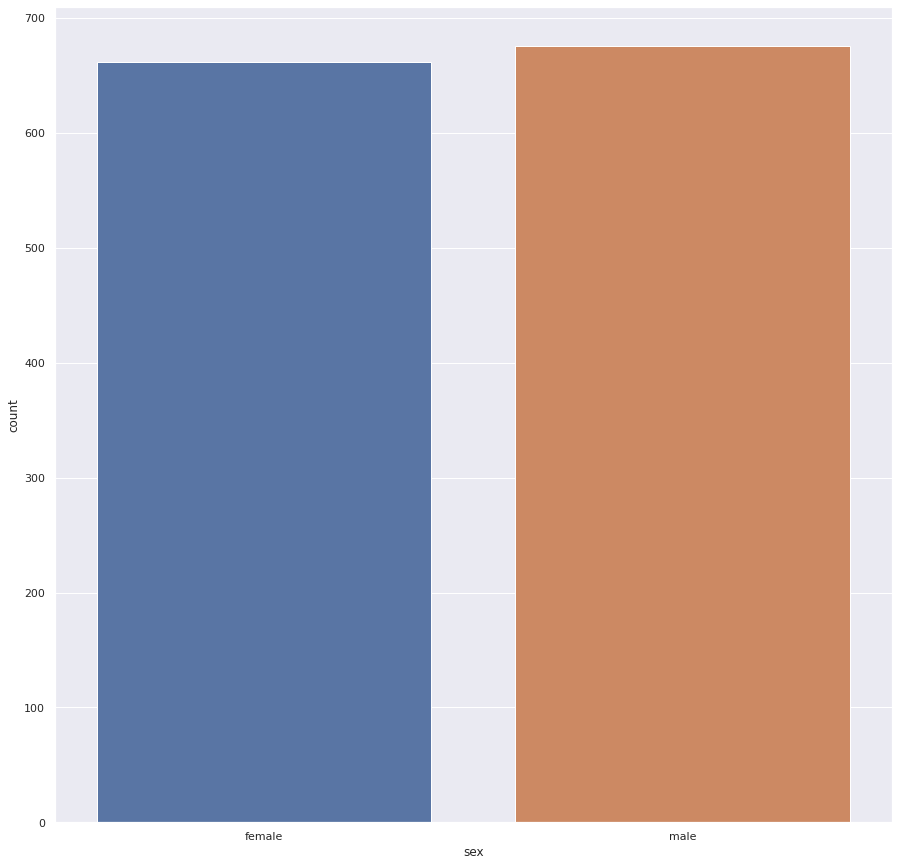

     smoker      Ratio
no     1064  79.521674
yes     274  20.478326
##########################################


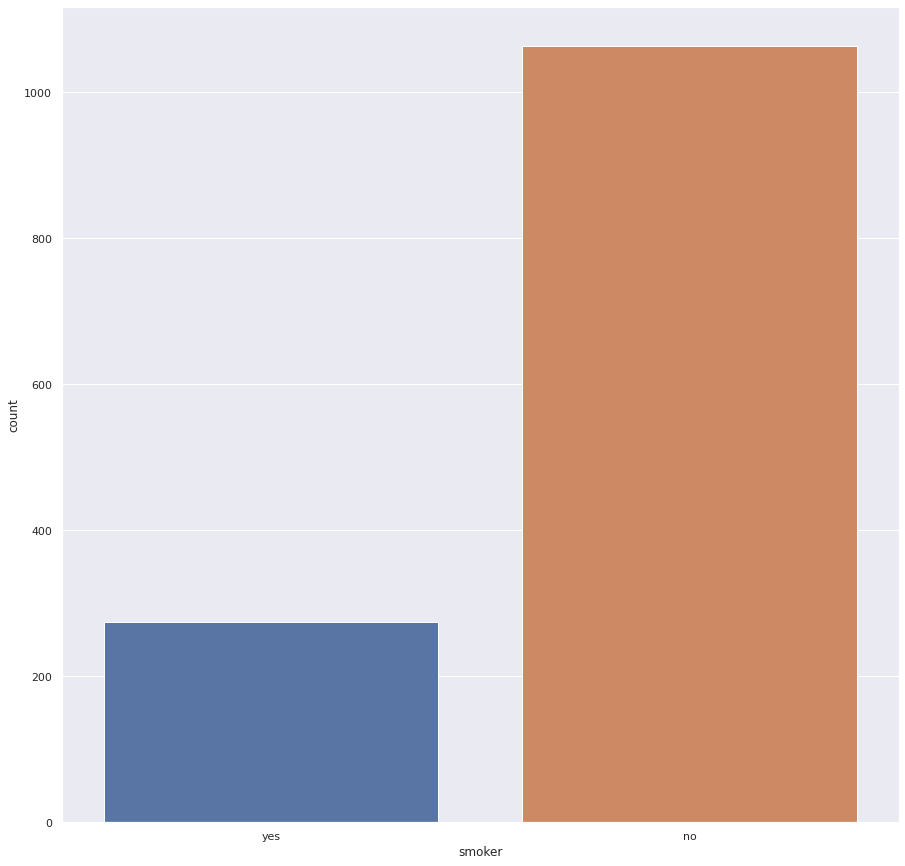

           region      Ratio
southeast     364  27.204783
southwest     325  24.289985
northwest     325  24.289985
northeast     324  24.215247
##########################################


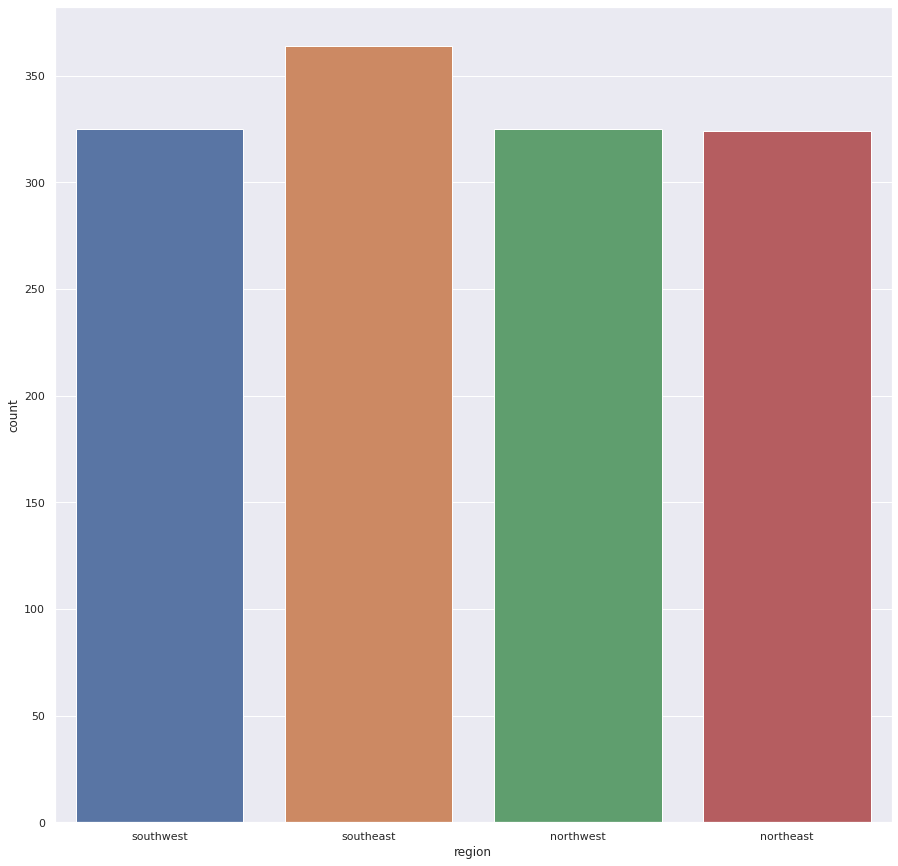

   children      Ratio
0       574  42.899851
1       324  24.215247
2       240  17.937220
3       157  11.733931
4        25   1.868460
5        18   1.345291
##########################################


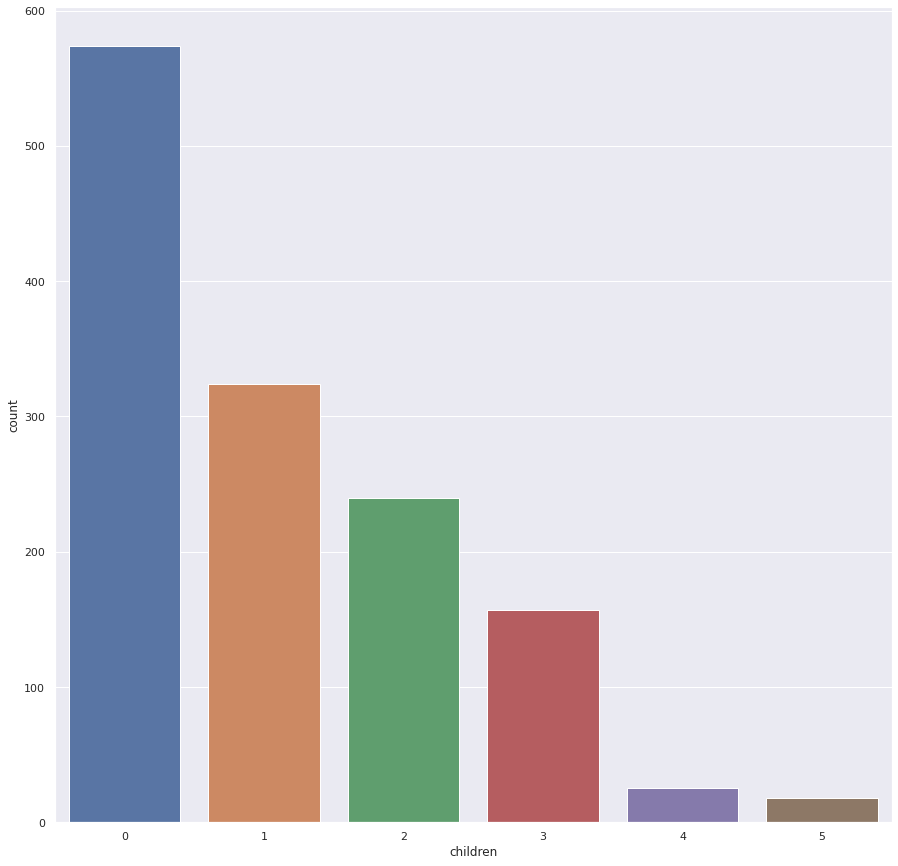

In [ ]:
for i in cat_cols:
  cat_summary(df,i,plot=True)

**Numerical Columns Visualization and Summarization**

##########################################

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
5%         18.000000
10%        19.000000
20%        24.000000
30%        29.000000
40%        34.000000
50%        39.000000
60%        44.000000
70%        49.000000
80%        54.000000
90%        59.000000
95%        62.000000
99%        64.000000
max        64.000000
Name: age, dtype: float64



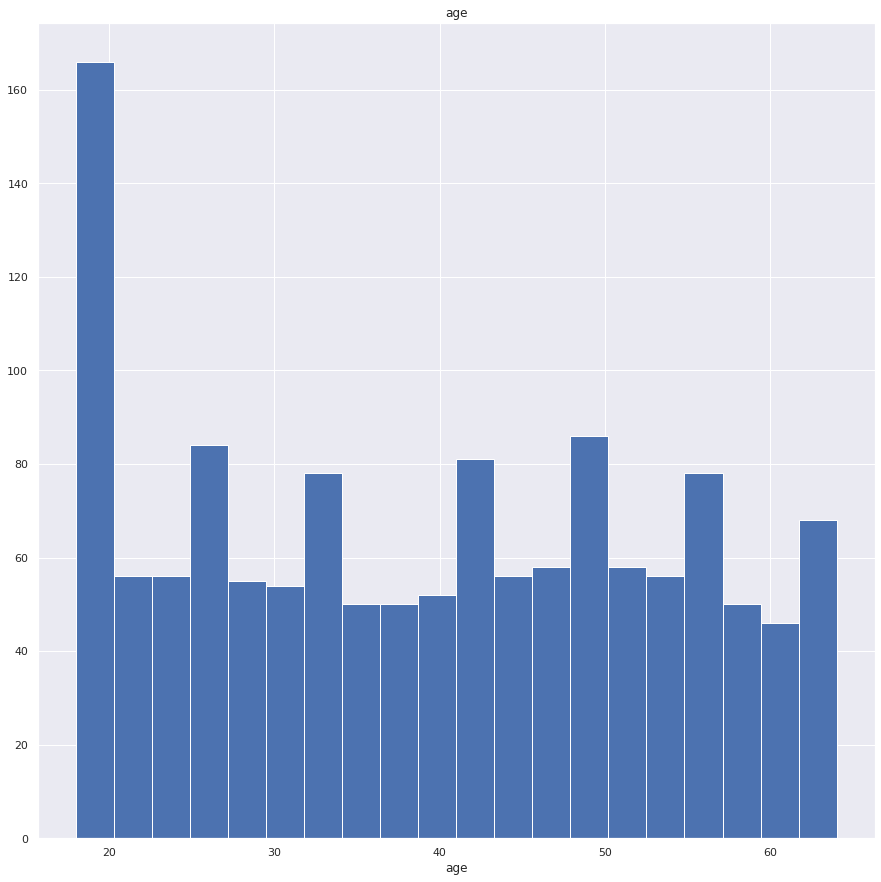

##########################################

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
5%         21.256000
10%        22.990000
20%        25.326000
30%        27.360000
40%        28.797000
50%        30.400000
60%        32.032000
70%        33.660000
80%        35.860000
90%        38.619500
95%        41.106000
99%        46.407900
max        53.130000
Name: bmi, dtype: float64



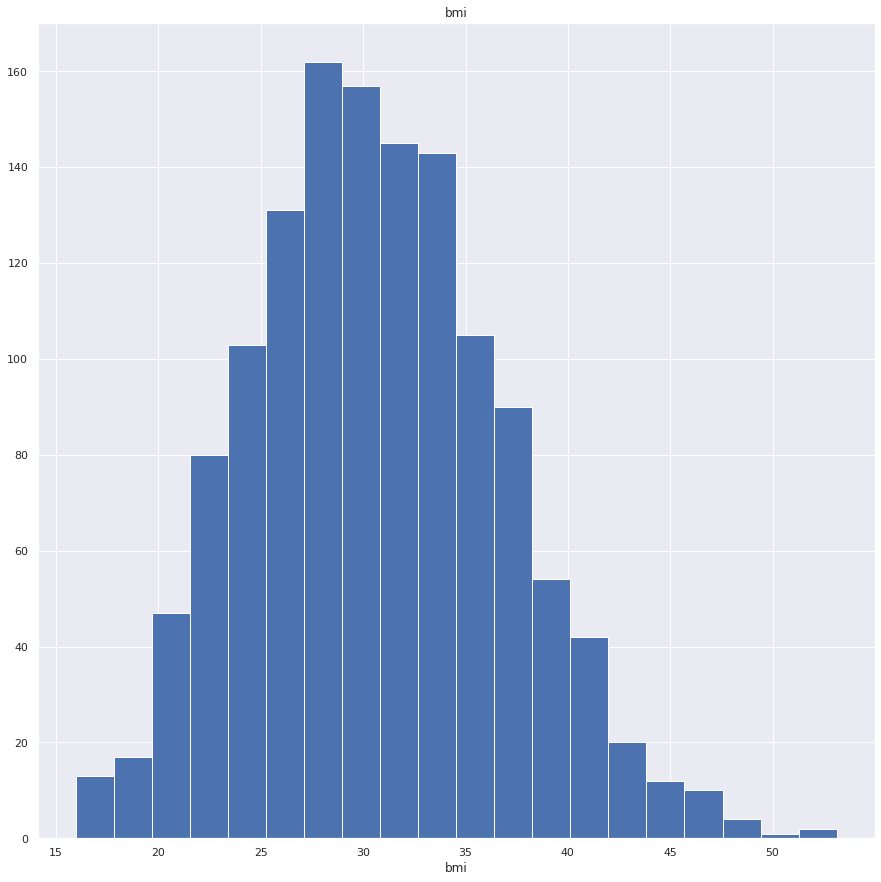

##########################################

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
5%        1757.753400
10%       2346.533615
20%       3991.575720
30%       5484.846770
40%       7369.052730
50%       9382.033000
60%      11399.857160
70%      13767.875345
80%      20260.626406
90%      34831.719700
95%      41181.827787
99%      48537.480726
max      63770.428010
Name: charges, dtype: float64



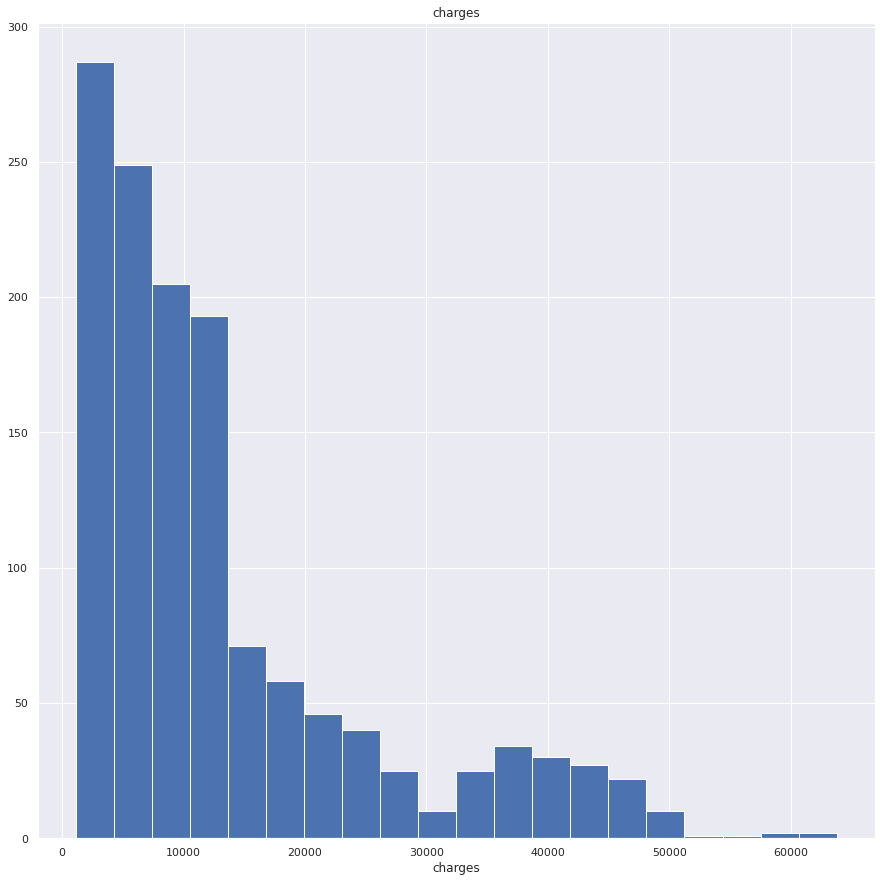

In [ ]:
for i in num_cols:
  num_summary(df,i,plot=True)

In [ ]:
for i in cat_cols:
  for j in num_cols:
    target_summary_with_cat(df,j,i)

Mean of age with respect to sex
        TARGET_MEAN
sex                
female    39.503021
male      38.917160


Mean of bmi with respect to sex
        TARGET_MEAN
sex                
female    30.377749
male      30.943129


Mean of charges with respect to sex
         TARGET_MEAN
sex                 
female  12569.578844
male    13956.751178


Mean of age with respect to smoker
        TARGET_MEAN
smoker             
no        39.385338
yes       38.514599


Mean of bmi with respect to smoker
        TARGET_MEAN
smoker             
no        30.651795
yes       30.708449


Mean of charges with respect to smoker
         TARGET_MEAN
smoker              
no       8434.268298
yes     32050.231832


Mean of age with respect to region
           TARGET_MEAN
region                
northeast    39.268519
northwest    39.196923
southeast    38.939560
southwest    39.455385


Mean of bmi with respect to region
           TARGET_MEAN
region                
northeast    29.173503
northwest   

**Relationship between smoker and charges**

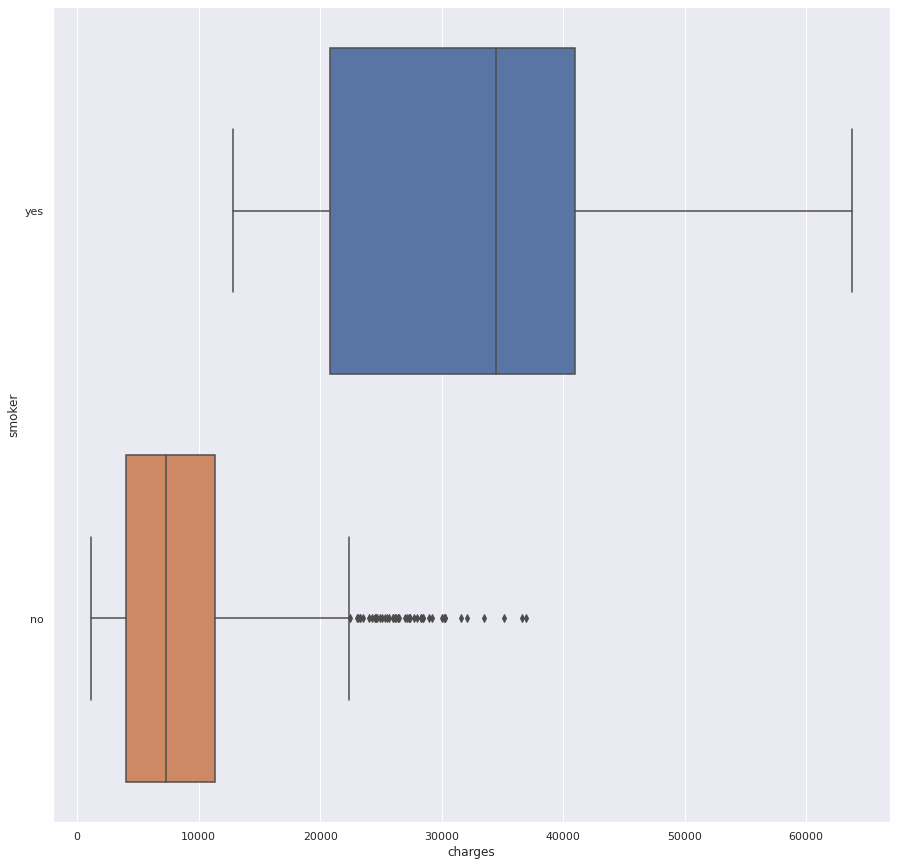

In [ ]:
sns.boxplot(data=df, x="charges", y="smoker", orient = "h")

**Relationship between bmi and sex**

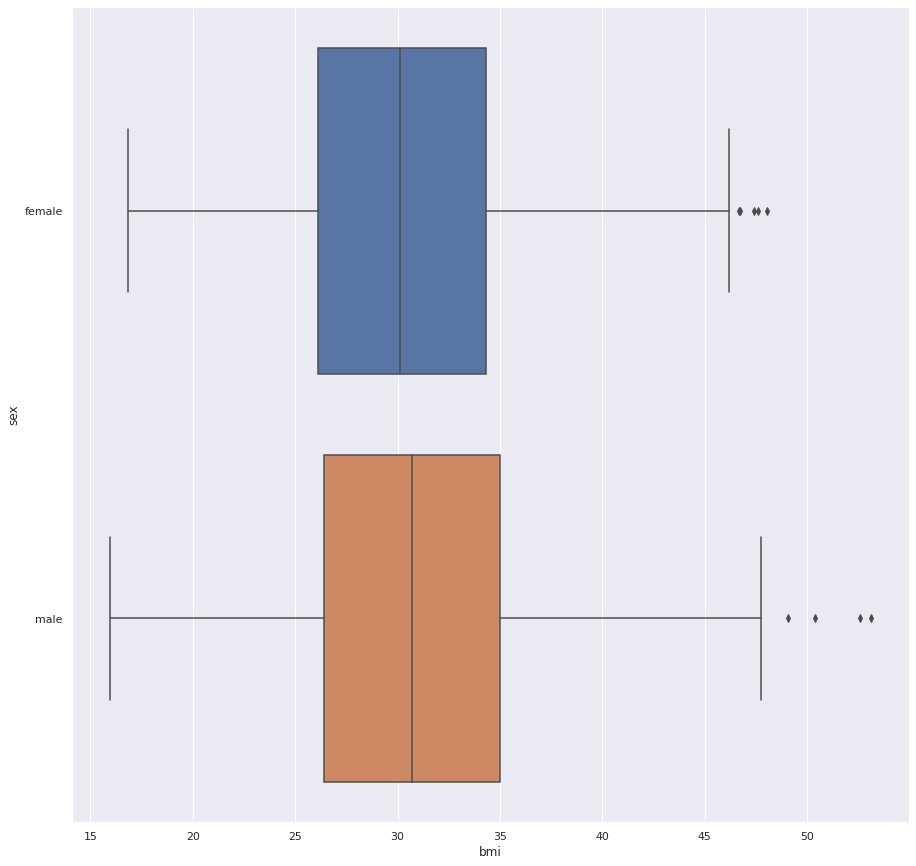

In [ ]:
sns.boxplot(data=df, x="bmi",y="sex")

**Find the "region" with the most "children"**

In [ ]:
df[["region","children"]].max() 
# Also we can use to see 'most children' more detailed  in regions df["children"].groupby(df["region"]).max()

region      southwest
children            5
dtype: object

**Relationship between age and bmi**

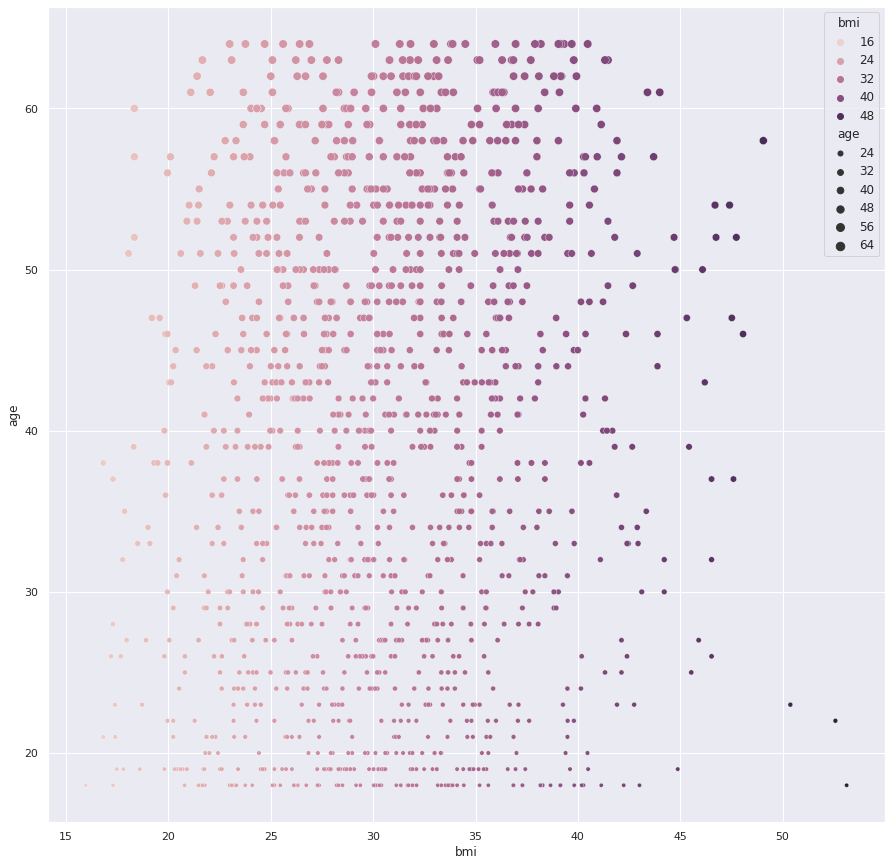

In [ ]:
sns.scatterplot(data=df, x="bmi", y="age",hue="bmi",size="age",legend="auto")


**Relationship between bmi and children**


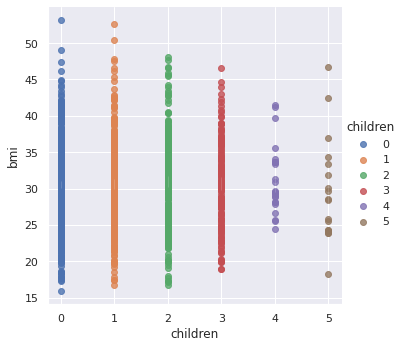

In [ ]:
sns.lmplot(data=df, x='children' , y = 'bmi', hue = 'children')


**Relationship between bmi and charges**


/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


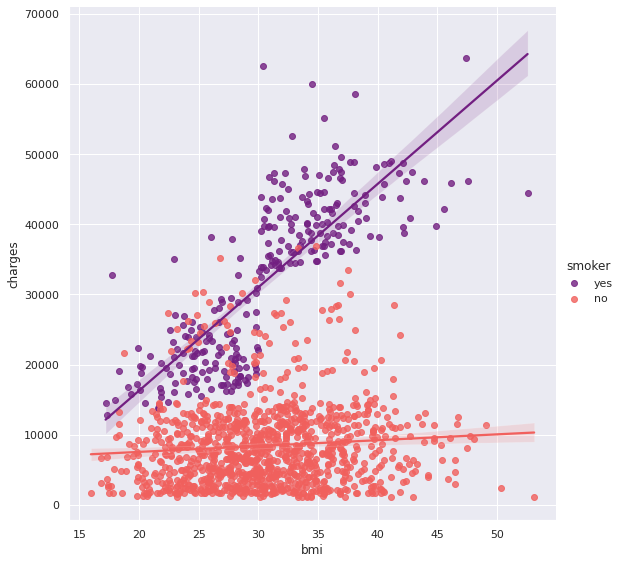

In [ ]:
sns.lmplot(x="bmi", y="charges", hue="smoker", data=df, palette = 'magma', size = 8)

**Relationship between region, smoker and bmi**

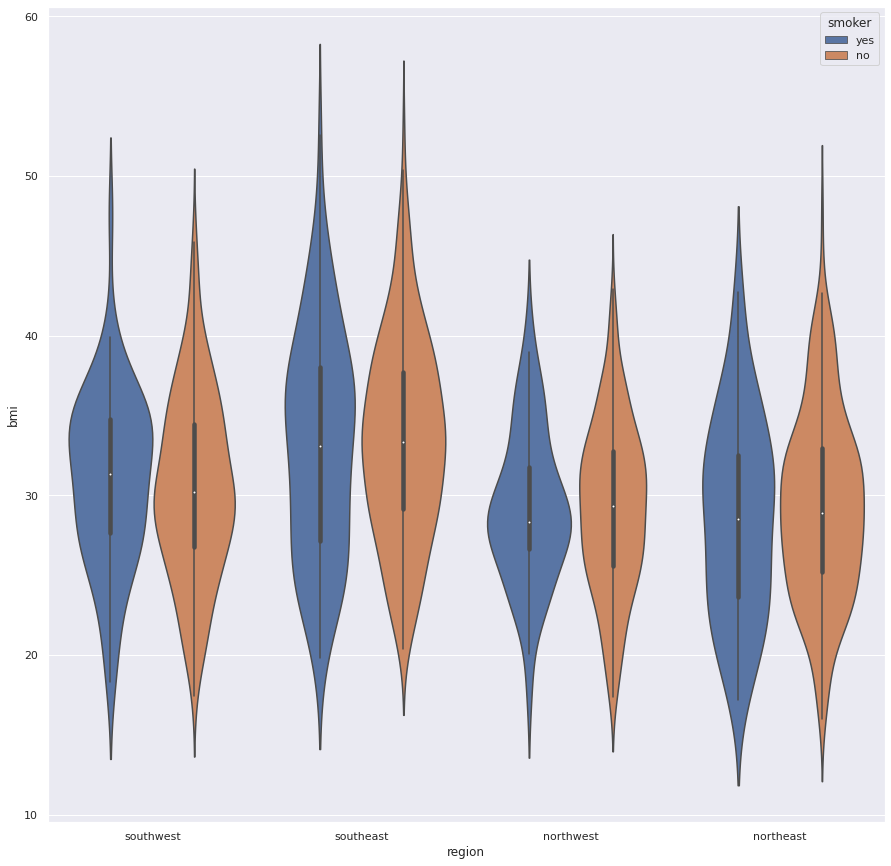

In [ ]:
sns.violinplot(data = df , x = 'region' , y = 'bmi', hue= 'smoker')

#**Data Preprocessing**
Include visualization of some columns that need label encoding

In [ ]:
def outlier_thresholds(dataframe, col_name, q1=0.10, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable, q1=0.10, q3=0.90):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def check_outlier(dataframe, col_name, q1=.10, q3=.90):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index


def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers


def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns


def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe



def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [ ]:
for i in num_cols:
  print(check_outlier(df,i))

False
False
False


In [ ]:
for i in num_cols:
  print(i,outlier_thresholds(df,i))

age (-41.0, 119.0)
bmi (-0.45424999999999827, 62.06374999999999)
charges (-46381.245512500005, 83559.4988275)


Label Encoding

In [ ]:
### Label Encoding on column sex

le = LabelEncoder()
df.sex = le.fit_transform(df.sex)

In [ ]:
### Label Encoding on column smoker

le = LabelEncoder()
df.smoker = le.fit_transform(df.smoker)

In [ ]:
### Label Encoding on column region

le = LabelEncoder()
df.region = le.fit_transform(df.region)

In [ ]:
### Parameters of label encoding for REGION column
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
print(dictionary)

{'northeast': 0, 'northwest': 1, 'southeast': 2, 'southwest': 3}


**Correlated Columns**

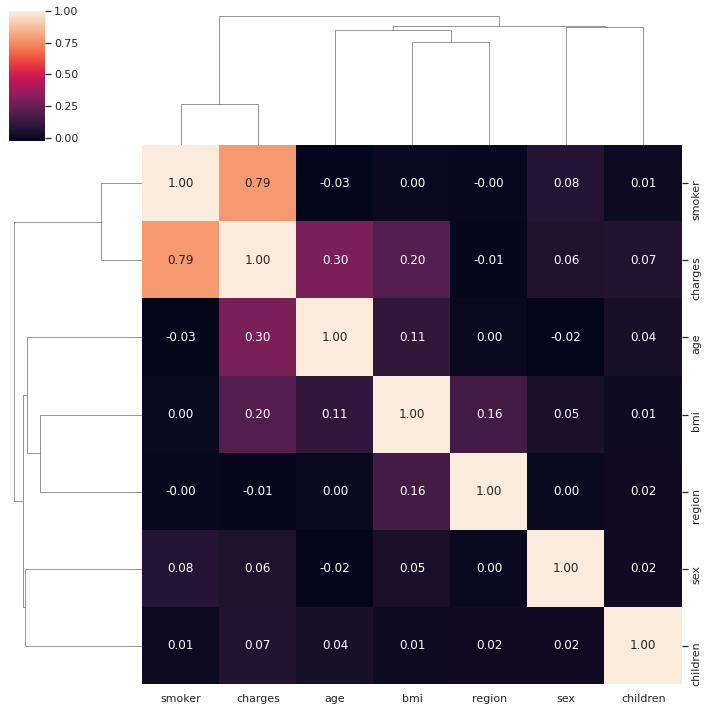

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

In [ ]:
target_correlation_matrix(df,corr_th=0.001, target ="bmi")

**Relationship between smoker and region**


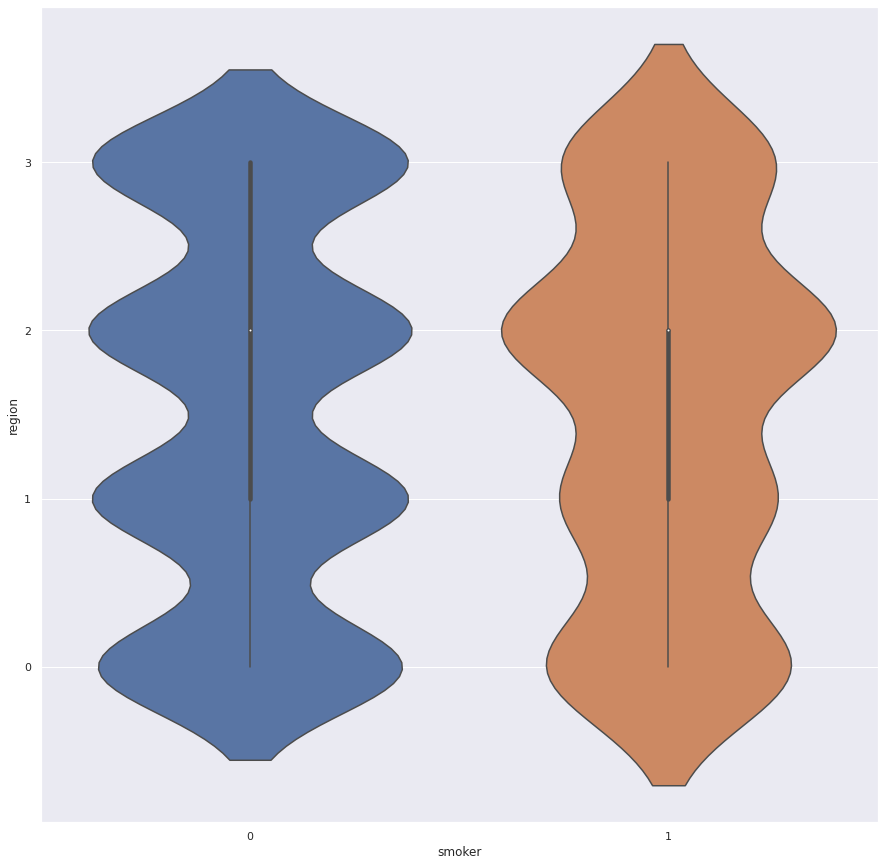

In [ ]:
sns.violinplot(data=df, x="smoker", y="region")
#regions'labels are {'northeast': 0, 'northwest': 1, 'southeast': 2, 'southwest': 3}


**Normalized Data**

In [ ]:
df_n = df.drop(['charges'], axis = 1)

normalized_df=(df_n-df_n.min())/(df_n.max()-df_n.min())
normalized_df["charges"] = df["charges"]

**Divide df as X,y for train_test_split**

In [ ]:
X = normalized_df.drop(['charges'], axis = 1)
Y = normalized_df.charges


**Split data as Train, Test**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=50)

#**Model Selection**

**Linear Regression**

In [ ]:
lr = LinearRegression()
model = lr.fit(x_train, y_train)

In [ ]:
x_train_pred = lr.predict(x_train)
x_test_pred = lr.predict(x_test)
print(model.intercept_)
print(model.coef_)
print(model.score(x_test, y_test))

-1460.5453222692504
[11564.13831736  -318.92989923 11256.88352765  2026.2818707
 23155.11187846  -481.64450229]
0.7854299998012869


**Hyper-parameter Optimization**

In [ ]:
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

xgb=XGBClassifier()
GBR = GradientBoostingRegressor()

parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
              'subsample'    : [0.9, 0.5, 0.2, 0.1],
              'n_estimators' : [100,500,1000, 1500],
              'max_depth'    : [4,6,8,10]
             }

randm_src = RandomizedSearchCV(estimator=GBR, param_distributions = parameters,scoring = "r2", cv = 10, n_iter = 10, n_jobs=-1)
randm_src.fit(x_train, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", randm_src.best_estimator_)
print("\n The best score across ALL searched params:\n", randm_src.best_score_)
print("\n The best parameters across ALL searched params:\n", randm_src.best_params_)

 Results from Random Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.03, max_depth=6, subsample=0.9)

 The best score across ALL searched params:
 0.8201674751384562

 The best parameters across ALL searched params:
 {'subsample': 0.9, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.03}


#**Model Evaluation**

**Predicting with model optimized**

In [ ]:
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, accuracy_score
randm_src_x_train_pred = randm_src.predict(x_train)
randm_src_x_test_pred = randm_src.predict(x_test)
print('MSE train data: %.3f, MSE test data: %.3f' % (
    mean_squared_error(y_train,randm_src_x_train_pred),
    mean_squared_error(y_test,randm_src_x_test_pred)))

print('MAE train data: %.3f, MAE test data: %.3f' % (
    mean_absolute_error(y_train,randm_src_x_train_pred),
    mean_absolute_error(y_test,randm_src_x_test_pred)))

print('R2 train data: %.3f, R2 test data: %.3f' % (
    r2_score(y_train,randm_src_x_train_pred),
    r2_score(y_test,randm_src_x_test_pred)))


MSE train data: 8073699.266, MSE test data: 23456890.582
MAE train data: 1679.613, MAE test data: 2894.006
R2 train data: 0.942, R2 test data: 0.857
